In [2]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [3]:
%matplotlib notebook

In [4]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [5]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [6]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

dff_nstds-thr-10.00


In [7]:
#### Create data ID for labeling figures with data-types
experiment = 'blobs'


# Output dir

In [8]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [9]:
pupildir = os.path.join(aggregate_dir, 'behavior-state', 'pupil')
print(pupildir)

if not os.path.exists(pupildir):
    os.makedirs(pupildir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil


#### Get metadata for stimulus

In [10]:
experiment = 'blobs'

In [11]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [12]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) 
                              for session, animalid, fovnum in zip(sdata_exp['session'].values, 
                                                                   sdata_exp['animalid'].values,
                                                                   sdata_exp['fovnum'].values)]

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [13]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
resp_filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [14]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

for k, v in exp_dkeys.items():
    print('%s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [15]:
# curr_datakeys = [k for k in stim_datakeys if k not in excl]
curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy().reset_index(drop=True)
# print(len(curr_sdata['datakey'].unique()), len(stim_datakeys))

In [16]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, resp_filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_nstds-thr-10.00


In [17]:
for datakey in stim_datakeys:
    print sdata_exp[sdata_exp['datakey']==datakey]['experiment'].values

['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['blobs' 'rfs']


In [18]:
curr_sdata.shape, sdata_exp.shape

((98, 7), (141, 7))

# Load gratings or blobs

In [19]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [20]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [21]:
# glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl' 
#                                                % (experiment, responsive_test, response_type)))

In [22]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[0]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

# Select stimuli

In [23]:
include_stimuli='all'

animalid = 'JC097'
session = '20190616'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()


Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static


In [24]:
sdf

,color,morphlevel,object,size,stimtype,xpos,ypos,yrot
config001,0.08,-1,control,10.0,image,25,-5,0
config002,0.2,-1,control,20.0,image,25,-5,0
config003,0.32,-1,control,30.0,image,25,-5,0
config004,0.44,-1,control,40.0,image,25,-5,0
config005,0.56,-1,control,50.0,image,25,-5,0
config006,,0,Blob_N1,10.0,image,25,-5,0
config007,,0,Blob_N1,20.0,image,25,-5,0
config008,,0,Blob_N1,30.0,image,25,-5,0
config009,,0,Blob_N1,40.0,image,25,-5,0
config010,,0,Blob_N1,50.0,image,25,-5,0


In [25]:
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (50 conditions)


In [26]:
print(datakey)
neuraldf = MEANS[datakey].copy()
print(neuraldf.shape)

20190616_JC097_fov1
(1500, 297)


# Face tracker data

In [27]:
dlc_home_dir = '/n/coxfs01/julianarhee/face-tracking'
dlc_project = 'facetracking-jyr-2020-01-25' #'sideface-jyr-2020-01-09'
dlc_project_dir = os.path.join(dlc_home_dir, dlc_project)
dlc_video_dir = os.path.join(dlc_home_dir, dlc_project, 'videos')

dlc_results_dir = os.path.join(dlc_project_dir, 'pose-analysis') # DLC analysis output dir

In [28]:
#### Training iteration info
dlc_projectid = 'facetrackingJan25'

scorer='DLC_resnet50'
iteration = 1
shuffle = 1
trainingsetindex=0
videotype='.mp4'

snapshot = 391800 #430200 #20900

DLCscorer = '%s_%sshuffle%i_%i' % (scorer, dlc_projectid, shuffle, snapshot)
print("Extracting results from scorer: %s" % DLCscorer)

Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800


In [29]:
glob.glob(os.path.join(dlc_project_dir, 'dlc-models', 'iteration-%i' % iteration,\
                      '%s-trainset95shuffle%i' % (dlc_projectid, shuffle), 'train', 'snapshot-*.meta'))


['/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391500.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391400.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391600.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391700.meta',
 '/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391800.meta']

#### Only include dsets with face-tracking

In [30]:
incl_skeys = list(set([os.path.split(f)[-1].split('_f')[0] for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))

incl_sessions = ['_'.join(s.split('_')[0:2]) for s in incl_skeys]
incl_ixs = [i for i in curr_sdata.index.tolist() if '_'.join([curr_sdata.loc[i]['session'], curr_sdata.loc[i]['animalid']]) in incl_sessions]

In [31]:
dsets = curr_sdata.iloc[incl_ixs]
dsets.groupby(['visual_area']).count()
dlc_datakeys = dsets['datakey'].unique()
exp_datakeys = curr_sdata['datakey'].unique()

print("%i of %i selected %s datasets with DLC." % (len(dlc_datakeys),len(exp_datakeys), experiment))


22 of 25 selected blobs datasets with DLC.


In [32]:
bstate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state'
pupil_fpath = glob.glob(os.path.join(bstate_dir, '%s_pupil-traces_snapshot-%i.pkl' % (experiment, snapshot)))[0]
print(pupil_fpath)

with open(pupil_fpath, 'rb') as f:
    PUPIL = pkl.load(f)

    # This is a dict, keys are datakeys



/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/blobs_pupil-traces_snapshot-391800.pkl


In [33]:
pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
pupiltraces.head()

,config,pupil,trial
0,config004,33.363709,1
1,config004,33.359263,1
2,config004,33.837850,1
3,config004,34.106828,1
4,config004,29.055174,1


# Load traces

In [34]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples

def resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=22.325):
    pupildfs = []
    min_nframes = int(round(np.mean([len(g) for p, g in pupiltraces.groupby(['trial'])])))
    #print(min_nframes)
    for trial, g in pupiltraces.groupby(['trial']):
        if len(g['pupil']) < min_nframes:
            npad = min_nframes - len(g['pupil'])
            vals = np.pad(g['pupil'].values, pad_width=((0, npad)), mode='edge')
        else:
            vals = g['pupil'].values[0:min_nframes]
        #print(len(vals))
        _, out_s = resample_traces(vals, in_rate=in_rate, out_rate=out_rate)
        currconfig = g['config'].unique()[0]
        pupildfs.append(pd.DataFrame({'pupil': out_s, 
                                       'config': [currconfig for _ in np.arange(0, len(out_s))],
                                       'trial': [trial for _ in np.arange(0, len(out_s))]} ))
    pupildfs = pd.concat(pupildfs, axis=0).reset_index(drop=True)
    return pupildfs


def zscore_array(v):
    return (v-v.mean())/v.std()

# Downsample and align traces

In [35]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))


Loading <dff> traces: test=nstds, thr=10.000


In [36]:

print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))

#### Load traces of responsive cells
traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                         response_type=response_type,
                                         responsive_test=responsive_test, 
                                         responsive_thr=responsive_thr)
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels.groupby(['trial']))
roi_list = traces.columns.tolist()



Loading <dff> traces: test=nstds, thr=10.000
Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... exp.load()
... loading saved data array (dff).
... updating self
... getting responsive cells (test: nstds, thr: 10.00')
... loading stats
296 of 432 cells responsive


In [37]:
# Get trial alignment info
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
alignment_info


{u'align_traces': True,
 u'append_trace_type': False,
 u'create_new': False,
 u'do_neuropil_correction': True,
 u'iti_post': u'1.0',
 u'iti_pre': u'1.0',
 u'ncores': 2,
 u'nonnegative': True,
 u'np_correction_factor': u'0.7',
 u'np_niterations': u'20',
 u'plot_psth': False,
 u'quantile': 0.10000000000000001,
 u'raw_only': True,
 u'save_warp_images': True,
 u'session': u'20190616',
 u'slurm': True,
 u'window_size_sec': 30.0}

In [39]:
# Temporal binning params
new_framerate = 20.0
framerate = 44.65

n_frames_bin = np.ceil(framerate/new_framerate) #11.
# new_framerate = framerate/n_frames_bin
new_framerate = (framerate/n_frames_bin)
print("Downsampled fr: %.2f Hz" % new_framerate)


#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(alignment_info['iti_pre'])
iti_post = float(alignment_info['iti_post'])
stim_dur = stim_on/framerate

#### Get indices of trial epochs to model
pre_flank = round((iti_pre)*44.65) #n_on/2.
post_flank = round((iti_post)*44.65)  #n_on

start_ix = int(stim_on-pre_flank)
end_ix = int(stim_on + n_on + post_flank + 1)
print(start_ix, end_ix, end_ix-start_ix)

#### Get resampled indices of trial epochs
_, out_ixs = resample_traces(np.arange(start_ix, end_ix), in_rate=44.65, out_rate=new_framerate)
new_stim_on = int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
print(new_stim_on)
new_n_on = int(round( stim_dur*new_framerate))
print(new_n_on)

Downsampled fr: 14.88 Hz
(0, 136, 136)
15
15


In [40]:
n_on

45.0

In [41]:
#### Only select trials where have pupil data
included_trial_nums = sorted(pupiltraces['trial'].unique())
#configs_on_included_trials = [trial_key[t] for t in included_trial_nums]
print('***including %i trials' % len(included_trial_nums))


***including 1500 trials


In [42]:
rid=90
# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]


#### Bin traces - Each tbin is a column, each row is a sample 
sample_data = trialmat.fillna(method='pad').copy()
binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
#r_list.append(r_)
    
r_['config'] = cfg_list

print(trialmat.shape, binned_trialmat.shape)


### Test traces

In [43]:
# Check with known config, known RID
ml=40 #-1
sz=20
#print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs_currcfg = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])
trial_ixs = np.array([t for t in trial_ixs_currcfg if t in included_trial_nums])
print("[%s] plotting %i of %i trials" % (cfg, len(trial_ixs), len(trial_ixs_currcfg)))

[config022] plotting 30 of 30 trials


((1500, 135), (1500, 45))


<IPython.core.display.Javascript object>


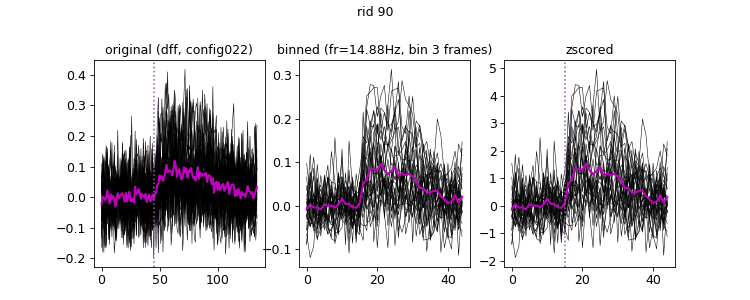

Text(0.5,0.98,u'rid 90')

In [45]:
print(trialmat.shape, binned_trialmat.shape)
#raw_ = trialmat.loc[included_trial_nums].copy()
#binned_ = binned_trialmat.loc[included_trial_nums].copy()
#zscored_ = zscored_neural.loc[included_trial_nums].copy()

fig, axn = pl.subplots(1, 3, figsize=(10,4))
ax=axn[0]; ax.set_title('original (%s, %s)' % (response_type, cfg));
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=stim_on, ls=':')

ax=axn[1]; ax.set_title('binned (fr=%.2fHz, bin %i frames)' % (new_framerate, n_frames_bin));
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)

ax=axn[2]; ax.set_title('zscored');
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')
pl.subplots_adjust(top=0.8)
pl.suptitle('rid %i' % rid)


#### Match pupil framerate

In [46]:
print(new_framerate)
#### Resample pupil
binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate)
pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                              index=binned_trialmat.index, columns=binned_trialmat.columns)
print(pupil_trialmat.shape)


14.8833333333
(1500, 45)


<IPython.core.display.Javascript object>


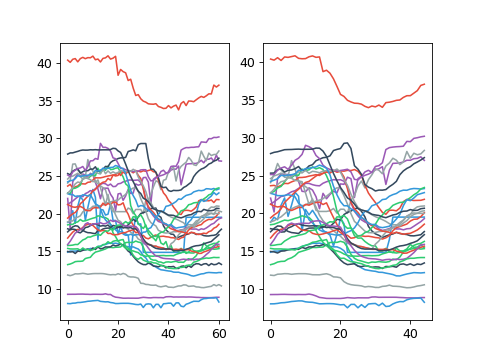

In [47]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
for t, pg in pupiltraces[pupiltraces['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)
ax=axn[1]
for t, pg in binned_pupil[binned_pupil['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)

<IPython.core.display.Javascript object>


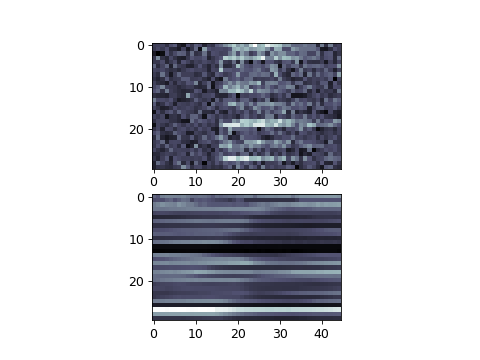

In [48]:
fig, axn = pl.subplots(2, 1)
ax=axn[0]
ax.imshow(binned_trialmat.loc[trial_ixs], cmap='bone')
ax=axn[1]
ax.imshow(pupil_trialmat.loc[trial_ixs], cmap='bone')


# Get all rois and traces

In [50]:
pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
print(pupil_r.shape)



(67500, 3)


In [51]:
r_list=[]
#rid=90
for rid in roi_list:
    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    included_trials = [trial for trial, tg in labels.groupby(['trial'])]


    #### Bin traces - Each tbin is a column, each row is a sample 
    sample_data = trialmat.fillna(method='pad').copy()
    binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
    n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

    #### Zscore traces 
    zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

    # Reshape roi traces
    cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
    r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
    r_list.append(r_)

traces_r = pd.concat(r_list, axis=1)
print(r_.shape, traces_r.shape)
traces_r['config'] = cfg_list

_, dii = np.unique(traces_r.columns, return_index=True)
traces_r = traces_r.iloc[:, dii]
print(traces_r.shape)


((67500, 3), (67500, 888))
(67500, 299)


In [219]:
binned_trialmat.shape # Ntrials # Nframes

(1500, 45)

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


#### Sort ROIs by correlation w/ pupil (for visualization)

In [53]:
pupil_values = pupil_r.sort_values(by=['trial', 'frame'])['pupil'].values

pupilcorrs = [np.corrcoef(traces_r.sort_values(by=['trial', 'frame_ix'])[rid], pupil_values)[0, 1] for rid in roi_list]


In [55]:
sorted_ixs = np.argsort(pupilcorrs)
# for ri in sorted_ixs:
#     print(ri, roi_list[ri], pupilcorrs[ri])
sorted_rids = np.array([roi_list[ri] for ri in sorted_ixs[::-1]])

In [56]:
# from matplotlib.colors import LinearSegmentedColormap

# cmap_name='nic_edge'
# cmap_dir='/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'

# #colormap = 'nic_Edge'
# #cmapdir = os.path.join(aggr_dir, 'colormaps')
# cdata = np.loadtxt(os.path.join(cmap_dir, cmap_name) + ".txt")
# cmap = LinearSegmentedColormap.from_list('my_colormap', cdata) #[::-1])
cmap='seismic'

In [57]:
new_stim_on, new_n_on

(15, 15)

In [58]:
on_frames = np.arange(new_stim_on, new_stim_on+new_n_on)
print(len(on_frames))
on_frames


15


array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [60]:
trial_ixs = sorted(pupil_r['trial'].unique())


<IPython.core.display.Javascript object>


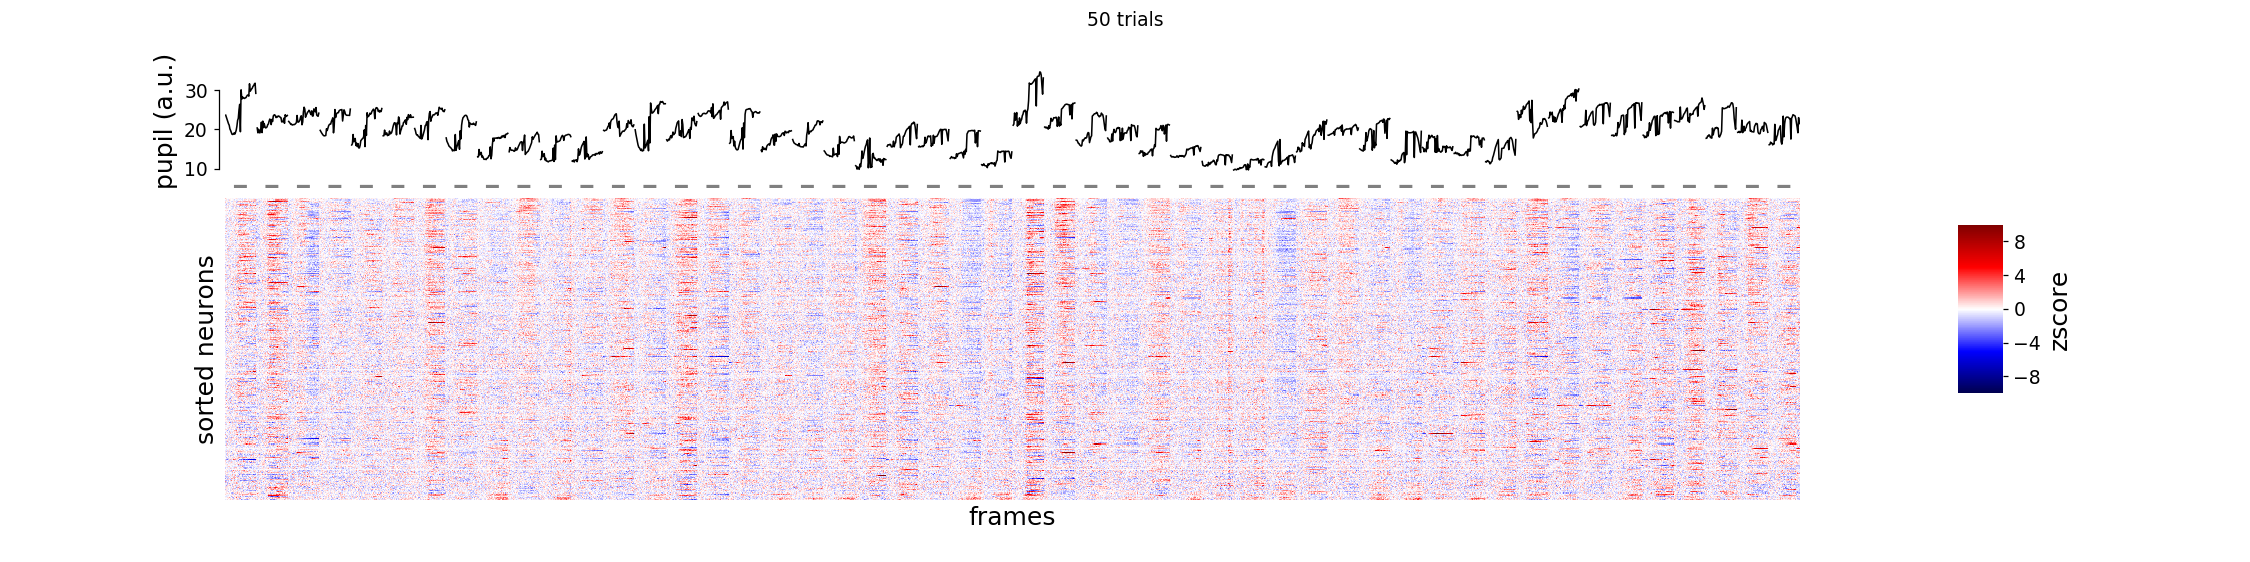

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil', 'sorted_neurons_pupil_trace_50trials_bin14fHz')


In [438]:
ntrials_plot = 50
start_trial = 500
pupil_lw=1
stim_lw=2

curr_trial_ixs = trial_ixs[start_trial:start_trial+ntrials_plot]
curr_pupil_trace = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].sort_values(by='trial')['pupil'].values
stim_ixs = [1 if f in on_frames else np.nan for f in pupil_r[pupil_r['trial'].isin(curr_trial_ixs)]['frame']]

curr_p = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].copy()
ix = curr_p.index.tolist()
on_ixs_global = [ix.index(i) for i in curr_p[curr_p['frame']==0].index.tolist()]
pvs = curr_pupil_trace.copy()
pvs[on_ixs_global] = np.nan

#fig, ax = pl.subplots()
grid_kws = {"height_ratios": (.25, 0.05, .7), "hspace": .005}
fig, (ax1, stimax, ax0) = pl.subplots(3,1, gridspec_kw=grid_kws, figsize=(20,5), dpi=dpi, sharex=True)

cbar_ax = fig.add_axes([.87, .3, .02, .3])
#im0 = ax.imshow(traces_r[roi_list].T, cmap='bone', aspect=200, vmin=-10, vmax=10)
#pl.colorbar(im0, ax=ax)
im0 = sns.heatmap(traces_r[traces_r['trial'].isin(curr_trial_ixs)][sorted_rids].T, ax=ax0,
                  cmap=cmap, center=0, vmin=-10, vmax=10,
                  cbar_ax=cbar_ax, cbar_kws={'label': 'zscore'})
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel('sorted neurons')
ax0.set_xlabel('frames')
             
nframes_total=len(pupil_r)
#divider = make_axes_locatable(ax)
#topax = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
ax1.plot(np.arange(0, len(curr_pupil_trace)), pvs, lw=pupil_lw, color='k')
ax1.set_ylabel('pupil (a.u.)')
#ax1.set_ylim([0, 50])

stimax.plot(np.arange(0, len(curr_pupil_trace)), stim_ixs, color='gray', lw=stim_lw)
stimax.tick_params(which='both', axis='both', size=0)
stimax.axis('off')


sns.despine(trim=True, bottom=True, ax=ax1, offset=4)
ax1.tick_params(axis='x', which='both', size=0)
ax1.set_xticks([])
pl.subplots_adjust(left=0.1, right=0.8)
fig.suptitle('%i trials' % ntrials_plot)


figname = 'sorted_neurons_pupil_trace_%itrials_bin%ifHz' % (ntrials_plot, new_framerate)
pl.savefig(os.path.join(pupildir, '%s.png' % figname))
print(pupildir, figname)

In [62]:
print(traces_r.shape, pupil_r.shape)
traces_r.head()


((67500, 299), (67500, 3))


,0,1,2,3,4,5,6,7,8,9,...,421,422,423,424,425,426,431,config,frame_ix,trial
0,-0.471805,-0.319094,-0.028293,-0.145418,-0.830232,-0.135684,-0.341904,-0.054460,0.471172,-0.455808,...,0.136718,-0.444097,-0.243794,-0.739853,0.112196,1.043947,0.625600,config004,-0.0,1
1,0.021812,-0.205405,0.261342,-0.798870,0.098517,0.523737,0.190045,-0.772927,0.506988,-0.789758,...,-0.160641,-0.413224,-1.205386,-1.325268,-1.467759,1.504130,0.061319,config004,1.0,1
2,0.438591,1.079580,0.126758,-0.300833,-0.080396,1.336609,-0.187320,-0.385058,-1.206449,0.903330,...,-0.215319,0.089100,-0.024670,-0.530026,-0.497091,0.129625,-1.317518,config004,2.0,1
3,0.226734,0.506918,-0.164047,0.692250,-1.005101,0.426621,0.231179,0.320794,0.910651,-0.307738,...,-0.240286,-0.190522,-1.033479,1.243518,0.474673,-0.980363,0.223284,config004,3.0,1
4,0.049863,-0.730224,-0.076030,-0.032361,-1.203148,-0.286428,0.112959,-0.353811,-0.547545,-0.592593,...,0.404396,0.346034,0.157396,-1.277072,-0.715348,0.193226,-0.165287,config004,4.0,1


# Create data frames for pupil/neural data - test low/high pupil

In [159]:
# neuraldf = pd.concat([g[roi_list].mean(axis=0) for t, g in traces_r.groupby(['trial'])], axis=1).T
# print(neuraldf.shape)
# config_list = [g['config'].unique()[0] for t, g in traces_r.groupby(['trial'])]

neuraldf=MEANS[datakey][roi_list]
neuraldf['config'] = config_list


In [92]:
pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
print(pupildf.shape)

pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])

(1500, 3)


<IPython.core.display.Javascript object>


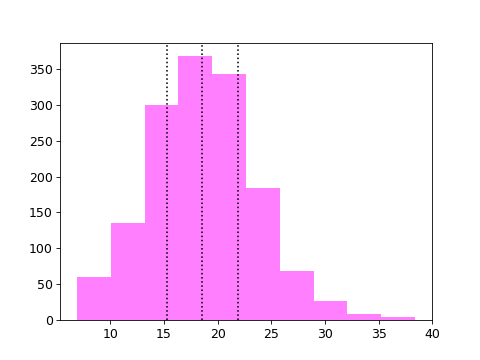

In [96]:
fig, ax = pl.subplots()
ax.hist(pupildf['pupil'], color='magenta', alpha=0.5)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k')

## Subdivide pupil levels into high/low

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import sklearn.metrics as skmetrics

In [112]:
import sklearn.metrics as skmetrics
import random

def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [167]:
def fit_svm(curr_data, sdf, m0=0, m100=106, C_value=1.0, n_iterations=100):

    iter_results=[]
    iter_results_chance=[]
    for iteration in np.arange(0, n_iterations):

        #### Select train/test configs for clf A vs B
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(object_configs)]

        #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
        zdata = sample_data[curr_roi_list]
        #zdata = (data - data.mean()) / data.std()

        #### Get labels
        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
        targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[]; 
        train_labels=[]; test_labels=[]; 
        train_data_chance=[]; test_data_chance=[]; 
        train_labels_chance=[]; test_labels_chance=[]; 
        for sz in sizes: 
            curr_configs = sdf[sdf['size']==sz].index.tolist()
            curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
            xi = zdata.loc[curr_trials]
            yi = targets.loc[curr_trials]['label'].values

            # Split train/test
            train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
            train_data.append(train_x)
            test_data.append(test_x)
            train_labels.append(train_y)
            test_labels.append(test_y)

        # Aggregate TRAIN/TEST data        
        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)
        test_data = np.vstack(test_data)
        test_labels = np.hstack(test_labels)

        #### DATA - Fit classifier
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())

        #### DATA - Test with held-out data
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)

        #### DATA - Calculate MI
        predicted_labels = trained_svc.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict.update({'heldout_test_score': test_score, 
                         'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

        # ------------------------------------------------------------------
        # Shuffle LABELS to calculate chance level
        train_labels_chance = train_labels.copy()
        np.random.shuffle(train_labels_chance)
        test_labels_chance = test_labels.copy()
        np.random.shuffle(test_labels_chance)

        #### CHANCE - Fit classifier
        svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

        # CHANCE - Test with held-out data
        trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
        test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

        # Chance - Calculate MI
        predicted_labels = trained_svc_chance.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

    # DATA - get mean across iters
    df = pd.concat(iter_results, axis=0)
    df_chance = pd.concat(iter_results_chance, axis=0)
    
    return df, df_chance


In [150]:
low_pupil_thr = pupil_quantiles[0.25]
high_pupil_thr = pupil_quantiles[0.75]

pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

# Get trial indices of low/high pupil 
low_trial_ixs = sorted(pupil_low['trial'].unique())
high_trial_ixs = sorted(pupil_high['trial'].unique())

#print(pupil_low.shape, pupil_high.shape)


(15.288976824099086, 21.854438354474439)
((375, 3), (375, 3), (750, 3))


In [117]:
m0=0
m100=106
C_value=1

n_iterations = 50

In [296]:
curr_data = neuraldf.copy()
df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
print("all: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))

# Fit LOW
curr_data = neuraldf.loc[low_trial_ixs].copy()
df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
print("low: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))

# Fit HIGH
curr_data = neuraldf.loc[high_trial_ixs].copy()
df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
print("high: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))


all: 0.10 (chance=0.00)
low: 0.00 (chance=-0.00)
high: 0.06 (chance=0.01)


In [227]:
m0=0
m100=106
C_value=1
n_iterations = 50
skip = ['20190420_JC076_fov1']

curr_dsets = dsets[dsets['visual_area']=='V1'].copy()
d_list=[]; d_list_chance=[]; dkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 
n_datakeys = len(curr_dsets['datakey'].unique())

for di, (datakey, ds) in enumerate(curr_dsets.groupby(['datakey'])):
    if datakey in skip:
        continue
        
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    neuraldf = MEANS[datakey].copy() #[roi_list]
    #neuraldf['config'] = config_list
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
    # Resample pupil traces
    binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate)
    # binned_trialmat.shape # Ntrials # Nframes
    trials_ = sorted(pupiltraces['trial'].unique())
    new_nframes_per_trial = binned_pupil.shape[0]/float(len(trials_))
    frames_ = np.arange(0, new_nframes_per_trial)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
                                  #index=binned_trialmat.index, columns=binned_trialmat.columns)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)


all: 0.50 (chance=0.01)
low: 0.42 (chance=0.03)
low: 0.32 (chance=0.00)
all: 0.29 (chance=0.01)
low: 0.07 (chance=0.02)
low: 0.18 (chance=0.01)
all: 0.16 (chance=0.00)
low: 0.03 (chance=0.02)
low: 0.02 (chance=0.01)
all: 0.28 (chance=0.00)
low: 0.01 (chance=0.01)
low: 0.10 (chance=0.01)
6 of 7 datakeys
all: 0.18 (chance=0.01)
low: 0.13 (chance=0.01)
low: -0.00 (chance=-0.01)
all: 0.10 (chance=0.00)
low: 0.00 (chance=-0.01)
low: 0.09 (chance=0.04)


In [228]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys



(12,)


In [301]:
full_df.head()

,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,datakey
0,0.004758,0.346440,0.495467,0.499807,0.883333,0.000863,0.808250,-2154.507472,0.232264,0.966761,-373.468449,0.866928,20190507_JC083_fov1
1,0.006810,0.206706,0.290534,0.298214,0.799000,0.000899,0.769239,-2592.829378,0.076043,0.930379,-782.257217,0.721258,20190522_JC084_fov1
2,0.006232,0.115261,0.156263,0.166286,0.726000,0.000891,0.703518,-3331.269901,-0.186951,0.884893,-1293.341367,0.539197,20190613_JC097_fov1
3,0.009844,0.196752,0.276214,0.283853,0.794667,0.001849,0.744406,-2871.858744,-0.023066,0.960357,-445.425505,0.841325,20190616_JC097_fov1
4,0.009995,0.129689,0.177963,0.187102,0.742333,0.002172,0.709607,-3262.854956,-0.162705,0.967491,-365.268858,0.869845,20190622_JC085_fov1


In [304]:
metric='heldout_test_score'

m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]


<IPython.core.display.Javascript object>


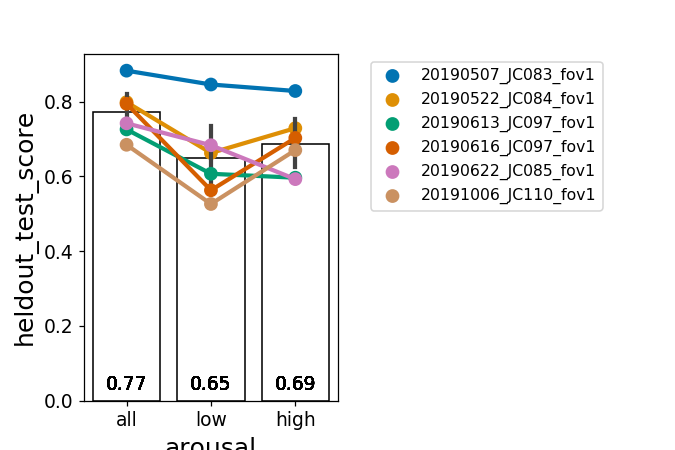

In [305]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


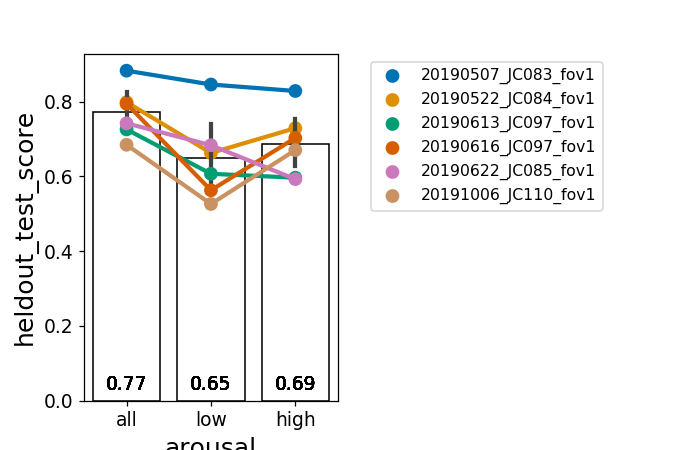

In [306]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


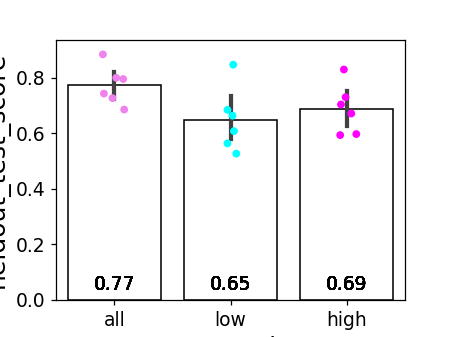

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
dtype: object

In [307]:
pupil_colors={'all': 'violet', 'low': 'aqua', 'high': 'magenta'}
fig, ax = pl.subplots(figsize=(4,3), dpi=dpi)
sns.stripplot(x='arousal', y=metric, data=m_df, ax=ax, palette=pupil_colors)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')


In [293]:
multi_comp_test='fdr_bh'
# Annotate w stats
print("********* [%s|%s] *********" % (experiment, metric))
#y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(m_df, metric=metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax) #, y_loc=y_loc, offset=1)


********* [blobs|heldout_aMI] *********


KeyError: 'visual_area'

# Load RF data

In [ ]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [ ]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)


#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

#### Get position info

In [ ]:
#if get_positions:
print("Calculating RF coord conversions...")
pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
for p in pos_params:
    rfdf[p] = ''
p_list=[]
for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)

    for ei, e_df in g.groupby(['experiment']):
        cell_ids = e_df['cell'].unique()
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rfdf[p][e_df.index] = p_[p].values
# with open(df_fpath, 'wb') as f:
#     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

#### Select subset of RF data

In [ ]:
r_list=[]
for datakey, expdf in corrs.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


#### Calculate overlap 

In [ ]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
n_dks = len(RFs['datakey'].unique())

o_list=[]
for di, ((visual_area, animalid, session, fovnum, datakey), g) in enumerate(RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey'])):
    if di%10==0:
        print("... %i of %i" % (int(di+1), n_dks))
        
    # convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)